I first import pandas and load the NELDA dataset into memory as a table

In [150]:
import pandas as pd
import numpy as np

In [151]:
nelda = pd.read_csv('NELDA2.csv')

Numberize simplifies NELDA columns by representing 'yes' datapoints as 1 and all other datapoints ('no' and 'unclear') as 0. Booltonum replaces 'True' values with 1 and 'False' values with 0.

In [152]:
def numberize(b):
    if b == 'yes':
        return 1
    else:
        return 0
    
def booltonum(b):
    if b:
        return 1
    else:
        return 0

I read in the polity-V dataset and shorten it to only the two variables I'm interested in.

In [153]:
p5 = pd.read_excel('p5v2018.xls')

In [154]:
p5short = p5[['ccode', 'country', 'year', 'exconst', 'polcomp']]

If data on executive-contraints does not exist for a particular year because Polity-V recorded it as a transitional period, I replace it with an average of the four previous years before the transition. If there aren't four year, I take the average of however many years there are. If there are no years before the transitional period, I leave that marker in place.

In [155]:
def adjexconst(row):
    if row['exconst'] == -88:
        previousyears = p5short[(p5short['year'] < row['year']) & (p5short['exconst'] != -88) & (p5short['ccode'] == row['ccode'])]
        numprevyears = previousyears.shape[0]
        if numprevyears >= 4:
            return previousyears.tail(4)['exconst'].mean()
        elif numprevyears > 0:
            return previousyears.tail(numprevyears)['exconst'].mean()
        else:
            return -88
    else:
        return row['exconst']
p5short['adjexconst'] = p5short.apply(adjexconst, axis=1)

C:\Users\sctap\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


I lag the year by one. However, for elections that happened the year a country was founded, I don't lag the year and merge them seperately.

In [156]:
p5short['year'] = p5short['year'] + 1

C:\Users\sctap\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [157]:
p5short['unlagyear'] = p5short['year'] - 1

C:\Users\sctap\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [158]:
neldawp5 = pd.merge(nelda, p5short, how='left', left_on=['ccode', 'year'], right_on=['ccode', 'year'])

I list the countries I couldn't match by using the year and country code or whose names differ in each of the datasets (possibly incorrect matches). Most are small island states that don't exist in Polity V. Others are just differences in naming convention. A few however present issues.

In [159]:
neldawp5[neldawp5['country_x'] != neldawp5['country_y']][['country_x', 'country_y']].drop_duplicates()

,country_x,country_y
0,United States of America,United States
75,Bahamas,NaN
83,Iceland,NaN
193,Barbados,NaN
203,Dominica,NaN
...,...,...
3689,Tuvalu,NaN
3699,Marshall Islands,NaN
3707,Palau,NaN
3720,Federated States of Micronesia,NaN


For instance, PolityV and Nelda use different country codes for post-unification Germany.

In [160]:
neldawp5[(neldawp5['country_x'] != neldawp5['country_y']) & (neldawp5['ccode'] == 260) & (neldawp5['year'] > 1990)][['country_x', 'country_y']]

,country_x,country_y
1207,German Federal Republic,NaN
1208,German Federal Republic,NaN
1209,German Federal Republic,NaN
1210,German Federal Republic,NaN
1211,German Federal Republic,NaN
1212,German Federal Republic,NaN


I manually input the correct PolityV polcomp and exconst values (which are constant over the timeperiod) into my table.

In [161]:
def fixgermanyissue(row):
    if row['ccode'] == 260 and row['year'] >= 1994:
        return ['Germany', float(8), float(10)]
    else:
        return [row['country_y'], row['exconst'], row['polcomp']]
temp = neldawp5.apply(fixgermanyissue, axis=1, result_type='expand')
neldawp5['country_y'] = temp[0]
neldawp5['exconst'] = temp[1]
neldawp5['polcomp'] = temp[2]

Similarly, Nelda and PolityV use different country-codes for Serbia following the dissolution of Yugoslavia and the break-up of Serbia and Montenegro. I manually move the appropriate values from one table to another.

In [162]:
neldawp5[(neldawp5['country_x'] != neldawp5['country_y']) & (neldawp5['ccode'] == 345) & (neldawp5['year'] > 1992)][['country_x', 'country_y']]

,country_x,country_y
1484,Serbia (Yugoslavia),NaN
1485,Serbia (Yugoslavia),NaN
1486,Serbia (Yugoslavia),NaN
1487,Serbia (Yugoslavia),NaN
1488,Serbia (Yugoslavia),NaN
1489,Serbia (Yugoslavia),NaN
1490,Serbia (Yugoslavia),NaN
1491,Serbia (Yugoslavia),NaN
1492,Serbia (Yugoslavia),NaN
1493,Serbia (Yugoslavia),NaN


In [163]:
neldawp5[(neldawp5['country_x'] != neldawp5['country_y']) & (neldawp5['ccode'] == 340) & (neldawp5['year'] >= 2007)][['country_x', 'country_y']]

,country_x,country_y
1427,Serbia,NaN
1428,Serbia,NaN
1429,Serbia,NaN
1430,Serbia,NaN
1431,Serbia,NaN
1432,Serbia,NaN
1433,Serbia,NaN
1434,Serbia,NaN


In [164]:
temp2 = p5short[p5short['ccode'] == 347]
def fixserbia(row):
    if row['ccode'] == 345 and row['year'] >= 1992 and row['year'] <= 2004:
        return np.array(temp2[(temp2['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    else:
        return [row['country_y'], row['exconst'], row['polcomp']]
temp3 = neldawp5.apply(fixserbia, axis=1, result_type='expand')
neldawp5['country_y'] = temp3[0]
neldawp5['exconst'] = temp3[1]
neldawp5['polcomp'] = temp3[2]

In [165]:
temp4 = p5short[p5short['ccode'] == 342]
def fixnewserbia(row):
    if row['ccode'] == 340 and row['year'] >= 2007:
        return np.array(temp4[(temp4['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    else:
        return [row['country_y'], row['exconst'], row['polcomp']]
temp5 = neldawp5.apply(fixnewserbia, axis=1, result_type='expand')
neldawp5['country_y'] = temp5[0]
neldawp5['exconst'] = temp5[1]
neldawp5['polcomp'] = temp5[2]

In the same manner as the examples above, I also manually match mismatched country-codes for Kosovo (2010-Present), the USSR (1946-1991), Ethiopia (1994-), Sudan (2012-), Yemen (1993-), Pakistan (1970), Vietnam (1981-), Montenegro (2008-), Kuwait (1961), Egypt (1950).

In [166]:
kosovo = p5short[p5short['ccode'] == 341]
ussr = p5short[p5short['ccode'] == 364]
ethiopia = p5short[p5short['ccode'] == 529]
nsudan = p5short[p5short['ccode'] == 626]
yemen = p5short[p5short['ccode'] == 679]
earlypak = p5short[p5short['ccode'] == 769]
viet = p5short[p5short['ccode'] == 818]
mont = p5short[p5short['ccode'] == 348]
def fixkosrus(row):
    if row['ccode'] == 347 and row['year'] >= 2010:
        return np.array(kosovo[(kosovo['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    elif row['ccode'] == 365 and row['year'] >= 1946 and row['year'] <= 1991:
        return np.array(ussr[(ussr['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    elif row['ccode'] == 530 and row['year'] >= 1994:
        return np.array(ethiopia[(ethiopia['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    elif row['ccode'] == 625 and row['year'] >= 2012:
        return np.array(nsudan[(nsudan['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    elif row['ccode'] == 651 and row['year'] == 1950:
        return ['Egypt', float(1), float(6)]
    elif row['ccode'] == 678 and row['year'] >= 1993:
        return np.array(yemen[(yemen['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    elif row['ccode'] == 690 and row['year'] == 1961:
        return ['Kuwait', float(2), float(1)]
    elif row['ccode'] == 770 and row['year'] == 1970:
        return np.array(earlypak[(earlypak['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    elif row['ccode'] == 816 and row['year'] >= 1981:
        return np.array(viet[(viet['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    elif row['ccode'] == 341 and row['year'] >= 2008:
        return np.array(mont[(mont['year'] == row['year'])][['country', 'exconst', 'polcomp']].iloc[0])
    else:
        return [row['country_y'], row['exconst'], row['polcomp']]
temp7 = neldawp5.apply(fixkosrus, axis=1, result_type='expand')
neldawp5['country_y'] = temp7[0]
neldawp5['exconst'] = temp7[1]
neldawp5['polcomp'] = temp7[2]

Next, I merge in elections that happened in the year a country was founded. A special case of elections that were missed when I lagged the Polity dataset by a year.

In [167]:
catchfoundings = pd.merge(neldawp5[neldawp5.country_y.isna()], p5short, how='left', left_on=['ccode', 'year'], right_on=['ccode', 'unlagyear'])

In [168]:
catchfoundings.drop(['country_y', 'exconst_x', 'polcomp_x', 'year_y', 'adjexconst_x'], axis=1, inplace=True)
catchfoundings.rename({'country': 'country_y', 'exconst_y': 'exconst', 'polcomp_y': 'polcomp', 'adjexconst_y': 'adjexconst'}, axis=1, inplace=True)

In [169]:
catchfoundings.rename({"year_x": 'year'}, axis=1, inplace=True)
catchfoundings.drop(['unlagyear_y', 'unlagyear_x'], axis=1, inplace=True)

In [170]:
neldawp5.drop(['unlagyear'], axis=1, inplace=True)

In [171]:
catchfoundings = catchfoundings[~catchfoundings['country_y'].isna()]

In [172]:
neldawp5 = neldawp5[~neldawp5.country_y.isna()]

In [173]:
frames = [neldawp5, catchfoundings]
neldawp5 = pd.concat(frames)

All the remaining cases of differing country names are now simply differences in naming convention.

In [174]:
neldawp5[neldawp5['country_x'] != neldawp5['country_y']][['country_x', 'country_y']].drop_duplicates()

,country_x,country_y
0,United States of America,United States
603,Surinam,Suriname
1196,German Federal Republic,Germany West
1207,German Federal Republic,Germany
1213,East Germany,Germany East
1346,Slovakia,Slovak Republic
1439,Macedonia (FYROM),Macedonia
1477,Serbia (Yugoslavia),Yugoslavia
1492,Serbia (Yugoslavia),Serbia and Montenegro
1494,Bosnia-Herzegovina,Bosnia


Finally, some founding elections are still missing adjusted execultive constraints, so I manually enter that data for Ethiopia's 1995 election, Pakistan's 1970 and Yemen's 1993 election. (Data doesn't match because of changes in country-code)

In [176]:
def latefix(row):
    if np.isnan(row['adjexconst']):
        if row['exconst'] == -88 and row['country_x'] == "Ethiopia":
            return 2.0
        elif row['exconst'] == -88 and (row['country_x'] == "Yemen" or row['country_x'] == "Pakistan"):
            return 3.0
        else:
            return row['exconst']
    else:
        return row['adjexconst']
X['adjexconst'] = X.apply(latefix, axis=1)

I create variables for the special Polity V cases of anarchy, transitions and occupation. I drop these elections later, except for transitional elections with a pre-transition executive constraint average. I drop transitional elections where there was no baseline (pre-transitional) value for executive constraints.

In [177]:
neldawp5['anarchy'] = (neldawp5['polcomp'] == -77) & (neldawp5['exconst'] == -77)
neldawp5['transition'] = (neldawp5['polcomp'] == -88) & (neldawp5['exconst'] == -88)
neldawp5['occupation'] = (neldawp5['polcomp'] == -66) & (neldawp5['exconst'] == -66)
neldawp5['droptransition'] = (neldawp5['exconst'] == -88) & (neldawp5['adjexconst'] < 0)

Next I import the Archigos political leader dataset.

In [178]:
import chardet

with open('Archigos.dta', 'rb') as f:
    print(chardet.detect(f.readline()))

{'encoding': 'Windows-1254', 'confidence': 0.6098425604005343, 'language': 'Turkish'}


In [179]:
archigos = pd.read_csv('archy.csv', encoding='Windows-1254')

For each leader, I find the start-year and end-year of their rule.

In [180]:
def getyear(adate):
    return int(adate[:4])
archigos['startyear'] = archigos['startdate'].apply(getyear)
archigos['endyear'] = archigos['enddate'].apply(getyear)

I lag the start-years and end-years by one, with important exceptions for countries with anually rotating heads-of-state (Switzerland) and a few countries in transition out of Nazi occupation in 1945 (Luxembourg, Austria, Hungary). For the president of Haiti in 2015, I lag the end-year by an extra year.

In [181]:
def yearsinpower(row):
    if row['ccode'] == 41 and row['leader'] == 'Martelly':
        return np.array(range(row['startyear'] + 1, row['endyear'] + 2))
    elif row['ccode'] == 225 and row['startyear'] == row['endyear']:
        return np.array(range(row['startyear'], row['endyear'] + 1))
    elif (row['ccode'] == 212 or row['ccode'] == 305 or row['ccode'] == 310) and row['startyear'] == 1945:
        return np.array(range(row['startyear'], row['endyear'] + 1))
    return np.array(range(row['startyear'] + 1, row['endyear'] + 1))

In [182]:
archigos['YearsinPower'] = archigos.apply(yearsinpower, axis=1)

In [183]:
def unnest(df, tile, explode):
    vals = df[explode].sum(1)
    rs = [len(r) for r in vals]
    a = np.repeat(df[tile].values, rs, axis=0)
    b = np.concatenate(vals.values)
    d = np.column_stack((a, b))
    return pd.DataFrame(d, columns = tile +  ['_'.join(explode)])

archunwound = unnest(archigos, ['ccode', 'yrborn', 'leader', 'startyear', 'endyear'], ['YearsinPower'])

I unwind the data for each leader into country-year format.

In [184]:
archunwound = archunwound.rename({'YearsinPower': 'year'}, axis=1)

Next, I calculate leader age and tenure by subtracting the year from their year of birth and the start of their rule respectively.

In [185]:
archunwound['age'] = archunwound['year'] - archunwound['yrborn']
archunwound['tenure'] = archunwound['year'] - archunwound['startyear']

I merge Archigos with NELDA.

In [186]:
archpvnelda = pd.merge(neldawp5, archunwound, how='left', left_on=['ccode', 'year'], right_on=['ccode', 'year'])

In [187]:
archpvnelda.drop(['startyear', 'endyear'], axis=1, inplace=True)

Next, I fix cases where the two datasets lacked matching country-codes. Montenegro (2008-), Russia(2000-), Yugoslavia(1945), Denmark (1945), Guinea-Bissau (2012).

In [188]:
def fixmissingleaders(row):
    if row['ccode'] == 341 and row['year'] >= 2008:
        return np.array([1954, "Vujanovic", row['year'] - 1954, row['year'] - 2003])
    elif row['ccode'] == 365 and row['year'] == 2000:
        return np.array([1952, "Putin", row['year'] - 1952, row['year'] - 2000])
    elif row['ccode'] == 345 and row['year'] == 1945:
        return np.array([1892, "Tito", row['year'] - 1892, row['year'] - 1945])
    elif row['ccode'] == 390 and row['year'] == 1945:
        return np.array([1881, "Buhl", row['year'] - 1881, row['year'] - 1945])
    elif row['ccode'] == 404 and row['year'] == 2012:
        return np.array([1947, "Sanha", row['year'] - 1947, row['year'] - 2009])
    else:
        return [row['yrborn'], row['leader'], row['age'], row['tenure']]
temp8 = archpvnelda.apply(fixmissingleaders, axis=1, result_type='expand')
archpvnelda['yrborn'] = temp8[0]
archpvnelda['leader'] = temp8[1]
archpvnelda['age'] = temp8[2]
archpvnelda['tenure'] = temp8[3]

Next, like with the Polity V merge, I merge in countries that enter the archigos dataset in 1945.

In [189]:
archunwound['unlagyear'] = archunwound['year'] - 1
foundings = pd.merge(archpvnelda[archpvnelda['age'].isna()], archunwound, how='left', left_on=['ccode', 'year'], right_on=['ccode', 'unlagyear'])
archpvnelda = archpvnelda[~archpvnelda['age'].isna()]
foundings.drop(['yrborn_x', 'leader_x', 'age_x', 'year_y', 'tenure_x', 'unlagyear'], axis=1, inplace=True)
foundings.rename({'leader_y': 'leader', 'age_y': 'age', 'tenure_y': 'tenure', 'year_x': 'year', 'yrborn_y': 'yrborn'}, axis=1, inplace=True)
frames = [archpvnelda, foundings]
archpvnelda = pd.concat(frames)

Next, I import Casey's dataset on Client Regimes.

In [190]:
clients = pd.read_csv('client_regimes.csv')

In [191]:
clients.columns

Index(['cowcode', 'year', 'gwf_casename', 'startdate', 'enddate', 'spell',
       'duration', 'gwf_fail', 'gwf_fail_subs', 'gwf_fail_type',
       'gwf_fail_violent', 'jan1leader', 'duration_ldr', 'ldr_fail',
       'ldr_fail_reg_fail', 'ldr_fail_reg_survive', 'spons', 'any_spons',
       'satellite', 'spons_spell', 'duration_spons', 'ptcoupsuccess',
       'ptcoupfail', 'regfailcoup', 'ldrcoup', 'american', 'russian', 'soviet',
       'prc_spons', 'british', 'french', 'viet_spons', 'yugo_spons',
       'egy_spons', 'comm_spons', 'coldwar', 'ally', 'commissar', 'cbcount',
       'pcount', 'party', 'personalist', 'military', 'monarchy', 'communist',
       'gdpcap', 'gdpcapl', 'logoil', 'e_civil_war', 'supportparty',
       'ldr_group_military', 'seizure_coup', 'seizure_rebel',
       'seizure_election'],
      dtype='object')

In [192]:
shortclients = clients[['cowcode', 'year', 'spons', 'gwf_casename']]

I merge in the clients data and create a clients column in the wider table for states identified by Casey as client states.

In [193]:
cliarchpvnelda = pd.merge(archpvnelda, shortclients, how='left', left_on=['ccode', 'year'], right_on=['cowcode', 'year'])
cliarchpvnelda['client'] = (~cliarchpvnelda['gwf_casename'].isna() & cliarchpvnelda['spons'])
cliarchpvnelda['client'].value_counts()

False    2889
True      458
Name: client, dtype: int64

Next, I merge in trade data from the correlates of war project. For my index of trade with major democracies, I calculate the total trade flow (imports and exports) of a country with five major democracies (the US, Japan, Germany, the UK, France) on a per-capita basis. I then add one to that number and take the log. I also lag my trade index by a year.

In [194]:
trade = pd.read_csv('Dyadic_COW_4.0.csv')
trade['year'] = trade['year'] + 1
bigdems = [2, 220, 255, 260, 200, 740]
trade['BigDem2'] = trade['ccode2'].apply(lambda x: x in bigdems)
trade['BigDem1'] = trade['ccode1'].apply(lambda x: x in bigdems)
tradewds = trade[((trade['BigDem1']) | (trade['BigDem2'])) & ~((trade['BigDem1']) & (trade['BigDem2']))]

In [195]:
def nonbigdem(row):
    if row['BigDem1']:
        return row['ccode2']
    else:
        return row['ccode1']
tradewds['RelCon'] = tradewds.apply(nonbigdem, axis=1)
tradewds = tradewds.groupby(['RelCon', 'year']).sum().reset_index()[['RelCon', 'year', 'flow1', 'flow2', 'smoothtotrade']]

C:\Users\sctap\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


I obtain population data from the national military capabilities dataset.

In [196]:
nmc = pd.read_csv('NMC_5_0.csv')
nmc['year'] = nmc['year'] + 1
tradewds = pd.merge(tradewds, nmc, how='left', left_on=['RelCon', 'year'], right_on=['ccode', 'year'])

In [197]:
tradewds[tradewds['ccode'].isna()].drop_duplicates('year')

,RelCon,year,flow1,flow2,smoothtotrade,stateabb,ccode,milex,milper,irst,pec,tpop,upop,cinc,version
93,20,2014,384113.3187,297084.6556,681197.9715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,20,2015,390153.5181,307182.2011,697335.7301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
tradewds['reltrade'] = (tradewds['flow1'] + tradewds['flow2']) / tradewds['tpop']
tradewds['trademissing'] = (tradewds['reltrade'] <= 0)

Where trade data is missing entirely, I fill in a trade value of zero.

In [199]:
def missing(s):
    if s <= 0:
        return 0
    else:
        return s
tradewds['reltrade'] = tradewds['reltrade'].apply(missing)
tradewds['reltradelog'] = np.log((tradewds['reltrade'] + 1))

Next, I create an index of membership in major liberal international organizations. I give one point for membership in the WTO, NATO, EU, GATT, OAS and the COE. Observers and associate members recieve half a point. I use correlates of war data.

In [200]:
iomembership = pd.read_csv('state_year_formatv3.csv')
relios = iomembership[['ccode', 'year', 'state', 'WTO', 'NATO', 'EU', 'GATT', 'OAS', 'COE']]
def memtotal(s):
    if s == 1:
        return 1
    if s == 2 or s == 3:
        return 0.5
    else:
        return 0
relios['sum'] = relios['WTO'].apply(memtotal) + relios['GATT'].apply(memtotal) + relios['NATO'].apply(memtotal) + relios['COE'].apply(memtotal) + relios['EU'].apply(memtotal) + relios['OAS'].apply(memtotal)

C:\Users\sctap\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In 1995, when GATT ended and was replaced by the WTO, I make sure to only add one point to each country for membership. 

In [201]:
def fix1995(row):
    if row['WTO'] == 1 and row['GATT'] == 1 and row['year'] == 1995:
        return row['sum'] - 1
    else:
        return row['sum']
relios['sum'] = relios.apply(fix1995, axis=1)

C:\Users\sctap\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


I merge all the correlates of war data together into one table. Because of the limits of Casey's client regime dataset and the correlates of war data, I prune the NELDA elections dataset to include only elections between 1945 and 2013 (inclusive).

In [202]:
cow = pd.merge(tradewds, relios, how='inner', left_on=['RelCon', 'year'], right_on=['ccode', 'year'])
cow = cow[['RelCon', 'state', 'year', 'reltrade', 'reltradelog', 'sum']]
testing = pd.merge(cliarchpvnelda, cow, how='left', left_on=['ccode', 'year'], right_on=['RelCon', 'year'])
testing4513 = testing[testing['year'] < 2014]

Next, I select only the elections that were competitive as defined by Hyde & Marinov (2012).

In [203]:
testing4513['Competitive'] = (testing4513['nelda3'] == 'yes') & (testing4513['nelda4'] == 'yes') & (testing4513['nelda5'] == 'yes')
testing4513 = testing4513[testing4513['Competitive']]

C:\Users\sctap\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


I further narrow down my domain to competitive elections where the election was for the highest office in that country

In [204]:
testing4513['National Executive'] = (testing4513['nelda20'] == 'yes')
testing4513 = testing4513[testing4513['National Executive']]

Next, I read in Data from the varieties of democracy country-year dataset. I use their index of electoral democracy.

In [205]:
vdem = pd.read_csv('V-Dem-CY-Core-v10.csv')
vdem = vdem[vdem['year'] > 1943]
vdem = vdem[['country_name', 'COWcode', 'year', 'v2x_polyarchy']]

I lag the Vdem data by a year

In [206]:
vdem['year'] = vdem['year'] + 1

Then I merge with my dataset

In [207]:
retesting = pd.merge(testing4513, vdem, how='left', left_on=['ccode', 'year'], right_on=['COWcode', 'year'])

We run into some familiar merging problems

In [208]:
retesting[retesting['country_name'] != retesting['country_x']][['country_x', 'country_name']].head(50)

,country_x,country_name
230,Surinam,Suriname
231,Surinam,Suriname
232,Surinam,Suriname
233,Surinam,Suriname
234,Surinam,Suriname
235,Surinam,Suriname
503,German Federal Republic,Germany
504,German Federal Republic,Germany
505,German Federal Republic,Germany
506,German Federal Republic,Germany


For instance, post 2008 Serbia once again has a different country code in Vdem than in NELDA

In [209]:
retesting[retesting['country_x'] == 'Serbia']

,stateid,ccode,country_x,electionid,year,mmdd,types,notes,nelda1,nelda1notes,...,RelCon,state,reltrade,reltradelog,sum,Competitive,National Executive,country_name,COWcode,v2x_polyarchy
607,SER,340,Serbia,340-2008-0120-P1,2008,120,Executive,This election was the first round of the Serbi...,no,NaN,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN
608,SER,340,Serbia,340-2008-0120-P2,2008,203,Executive,This election was the second round of the Serb...,no,NaN,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN
609,SER,340,Serbia,340-2012-0506-P1,2012,506,Executive,Serbia is a parliamentary republic. The execut...,no,NaN,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN
610,SER,340,Serbia,340-2012-0506-P2,2012,520,Executive,Serbia is a parliamentary republic. The execut...,no,NaN,...,NaN,NaN,NaN,NaN,NaN,True,True,NaN,NaN,NaN


The two problem countries (for the purpose of my analysis. Germany has mismatching country codes, but because German elections are democratic and will soon be dropped from the dataset anyway, I don't need to manually match that case) are Serbia and Yemen, so I manually match those.

In [210]:
serbia = vdem[vdem['country_name'] == 'Serbia']
yemen = vdem[vdem['country_name'] == 'Yemen']
def addserbiayem(row):
    if row['ccode'] == 678 and row['year'] >= 1999 and row['year'] <= 2006:
        return np.array(yemen[(yemen['year'] == row['year'])][['country_name', 'COWcode', 'v2x_polyarchy']].iloc[0])
    elif row['ccode'] == 340 and row['year'] >= 2008 and row['year'] <= 2012:
        return np.array(serbia[(serbia['year'] == row['year'])][['country_name', 'COWcode', 'v2x_polyarchy']].iloc[0])
    else:
        return [row['country_name'], row['COWcode'], row['v2x_polyarchy']]
storefixed = retesting.apply(addserbiayem, axis=1, result_type='expand')
retesting['country_name'] = storefixed[0]
retesting['COWcode'] = storefixed[1]
retesting['v2x_polyarchy'] = storefixed[2]

I consider countries with an electoral democracy index below 0.6 to be electoral autocracies.

In [211]:
retesting['Electoral Autocracy'] = retesting['v2x_polyarchy'] <= 0.6
retesting = retesting[retesting['Electoral Autocracy']]

Now I circle back to fix mismatching country-codes between NELDA and the correlates of war data. I find 16 entries in my table that are missing the COW data.

In [212]:
retesting[retesting['state'].isna()]

,stateid,ccode,country_x,electionid,year,mmdd,types,notes,nelda1,nelda1notes,...,state,reltrade,reltradelog,sum,Competitive,National Executive,country_name,COWcode,v2x_polyarchy,Electoral Autocracy
0,USA,2,United States of America,002-1948-1102-P1,1948,1102,Executive,Truman's first campaign for presidency; consid...,no,NaN,...,NaN,NaN,NaN,NaN,True,True,United States of America,2.0,0.587,True
454,FRN,220,France,220-1945-1021-A1,1945,1021,Constituent Assembly,These was the first national election since 19...,yes,NaN,...,NaN,NaN,NaN,NaN,True,True,France,220.0,0.092,True
455,FRN,220,France,220-1946-0602-A1,1946,602,Constituent Assembly,This represented a setback for left wing parti...,no,NaN,...,NaN,NaN,NaN,NaN,True,True,France,220.0,0.175,True
456,FRN,220,France,220-1946-1110-L1,1946,1110,Legislative/Parliamentary,First National Assembly election; kept the Thr...,yes,NaN,...,NaN,NaN,NaN,NaN,True,True,France,220.0,0.175,True
621,CRO,344,Croatia,344-1992-0802-P1,1992,802,Executive,NaN,yes,These were the first elections post-independence,...,NaN,NaN,NaN,NaN,True,True,Croatia,344.0,0.246,True
800,NOR,385,Norway,385-1945-1008-L1,1945,1008,Legislative/Parliamentary,NaN,yes,NaN,...,NaN,NaN,NaN,NaN,True,True,Norway,385.0,0.102,True
817,DEN,390,Denmark,390-1945-1030-L1,1945,1030,Legislative/Parliamentary,First elections since independence from occupy...,no,NaN,...,NaN,NaN,NaN,NaN,True,True,Denmark,390.0,0.199,True
1156,YEM,678,Yemen,678-1999-0923-P1,1999,923,Executive,NaN,no,While Parliament routinely selected the presid...,...,NaN,NaN,NaN,NaN,True,True,Yemen,679.0,0.290,True
1157,YEM,678,Yemen,678-2006-0920-P1,2006,920,Executive,"President Ali Abdullah SALEH, who had been in ...",no,NaN,...,NaN,NaN,NaN,NaN,True,True,Yemen,679.0,0.328,True
1196,JPN,740,Japan,740-1952-1001-L1,1952,1001,Legislative/Parliamentary,These were the first elections since the end o...,no,NaN,...,NaN,NaN,NaN,NaN,True,True,Japan,740.0,0.374,True


I choose to drop the French elections of 1945 and 1946 as well as Norway's 1945 election and Denmark's 1945 election. Those took place in the aftermath of Nazi occupation and they can't be considered to take place in an electoral autocracy. I also drop Japan's 1952 election (which took place under US occupation) and the US presidential election of 1948. 

In [213]:
retesting.drop([0, 454, 455, 456, 800, 817, 1196], inplace=True)

A few elections are still missing data, so I fill in those values manually. 

In [214]:
retesting[retesting['state'].isna()]

,stateid,ccode,country_x,electionid,year,mmdd,types,notes,nelda1,nelda1notes,...,state,reltrade,reltradelog,sum,Competitive,National Executive,country_name,COWcode,v2x_polyarchy,Electoral Autocracy
621,CRO,344,Croatia,344-1992-0802-P1,1992,802,Executive,NaN,yes,These were the first elections post-independence,...,NaN,NaN,NaN,NaN,True,True,Croatia,344.0,0.246,True
1156,YEM,678,Yemen,678-1999-0923-P1,1999,923,Executive,NaN,no,While Parliament routinely selected the presid...,...,NaN,NaN,NaN,NaN,True,True,Yemen,679.0,0.290,True
1157,YEM,678,Yemen,678-2006-0920-P1,2006,920,Executive,"President Ali Abdullah SALEH, who had been in ...",no,NaN,...,NaN,NaN,NaN,NaN,True,True,Yemen,679.0,0.328,True
1435,UKR,369,Ukraine,369-1991-1201-P1,1991,1201,Executive,NaN,yes,Ukraine did not declare independence until Aug...,...,NaN,NaN,NaN,NaN,True,True,Ukraine,369.0,0.373,True
1437,UZB,704,Uzbekistan,704-1991-1229-P1,1991,1229,Executive,NaN,no,NaN,...,NaN,NaN,NaN,NaN,True,True,Uzbekistan,704.0,0.219,True
1439,ARM,371,Armenia,371-1991-1016-P1,1991,1016,Executive,NaN,yes,NaN,...,NaN,NaN,NaN,NaN,True,True,Armenia,371.0,0.581,True
1440,BEN,434,Benin,434-1960-1211-L1,1960,1211,Legislative/Parliamentary,NaN,no,NaN,...,NaN,NaN,NaN,NaN,True,True,Benin,434.0,0.162,True
1441,BEN,434,Benin,434-1960-1211-P1,1960,1211,Executive,This was the first presidential election since...,yes,Benin (then called Dahomey) became independent...,...,NaN,NaN,NaN,NaN,True,True,Benin,434.0,0.162,True
1444,TAJ,702,Tajikistan,702-1991-1124-P1,1991,1124,Executive,NaN,no,NaN,...,NaN,NaN,NaN,NaN,True,True,Tajikistan,702.0,0.271,True


In [215]:
yemen = cow[cow['RelCon'] == 679]
def fixtesting(row):
    if row['ccode'] == 678 and row['year'] >= 1991:
        return np.array(yemen[(yemen['year'] == row['year'])][['RelCon', 'state', 'reltrade', 'reltradelog', 'sum']].iloc[0])
    elif row['ccode'] == 344 and row['year'] == 1992:
        return np.array([344, 'croatia', 0, 0, float(0)])
    elif row['ccode'] == 704 and row['year'] == 1991:
        return np.array([704, 'uzbekistan', 0, 0, float(0)])
    elif row['ccode'] == 434 and row['year'] == 1960:
        return np.array([434, 'benin', 0.006661, 0.006639, float(0)])
    elif row['ccode'] == 702 and row['year'] == 1991:
        return np.array([702, 'tajikistan', 0, 0, float(0)])
    elif row['ccode'] == 371 and row['year'] == 1991:
        return np.array([371, 'armenia', 0, 0, float(0)])
    elif row['ccode'] == 369 and row['year'] == 1991:
        return np.array([369, 'ukraine', 0, 0, float(0)])
    else:
        return [row['RelCon'], row['state'], row['reltrade'], row['reltradelog'], row['sum']]
temp10 = retesting.apply(fixtesting, axis=1, result_type='expand')
retesting['RelCon'] = temp10[0]
retesting['state'] = temp10[1]
retesting['reltrade'] = temp10[2]
retesting['reltradelog'] = temp10[3]
retesting['sum'] = temp10[4]

I rename some columns for clarity and replace 'yes' and 'no' with 1 and 0.

In [216]:
retesting['ReliablePolls'] = retesting['nelda25'].apply(numberize)
retesting['PollsGood'] = retesting['nelda26'].apply(numberize)
retesting['IncumbentRan'] = retesting['nelda21'].apply(numberize)
retesting['ChosenSuccessor'] = retesting['nelda22'].apply(numberize)
retesting['SuccessorWin'] = retesting['nelda23'].apply(numberize)
retesting['IncPartyLost'] = retesting['nelda24'].apply(numberize)
retesting['GoodEcon'] = retesting['nelda17'].apply(numberize)
retesting['OppBoycott'] = retesting['nelda14'].apply(numberize)
retesting['IncRepl'] = retesting['nelda39'].apply(numberize)
retesting['PostProtest'] = retesting['nelda29'].apply(numberize)
retesting['PostProtestFraud'] = retesting['nelda30'].apply(numberize)
retesting['OppGain'] = retesting['nelda27'].apply(numberize)
retesting['EconCrisis'] = retesting['nelda18'].apply(numberize)
retesting['Transitional'] = retesting['nelda10'].apply(numberize)
retesting['Leverage'] = retesting['nelda57'].apply(numberize)
retesting['Leverage2'] = retesting['nelda58'].apply(numberize)
retesting['Harrass'] = retesting['nelda15'].apply(numberize)

I select only elections where the incumbent or a chosen successor was on the ballot representing the regime.

In [217]:
retesting['Incumbent or Successor'] = (retesting['IncumbentRan'] == 1) | (retesting['ChosenSuccessor'] == 1)
retesting = retesting[retesting['Incumbent or Successor']]

I define opposition victories as elections where the incumbent party lost or a chosen successor lost.

In [218]:
retesting['oppwin'] = ((retesting['ChosenSuccessor'] == 1) & (retesting['SuccessorWin'] == 0)) | (retesting['IncPartyLost'] == 1)
retesting['oppwin'] = retesting['oppwin'].apply(booltonum)

In [219]:
retesting['leverage'] = retesting['Leverage'] | retesting['Leverage2']
retesting['leverage'] = retesting['leverage'].apply(booltonum)
retesting['anarchy'] = retesting['anarchy'].apply(booltonum)
retesting['transition'] = retesting['transition'].apply(booltonum)
retesting['occupation'] = retesting['occupation'].apply(booltonum)
retesting['droptransition'] = retesting['droptransition'].apply(booltonum)
retesting.rename({'sum': 'IOScore'}, axis=1, inplace=True)
retesting['PostCW'] = retesting['year'] >= 1990
retesting['PostCW'] = retesting['PostCW'].apply(booltonum)
retesting['client'] = retesting['client'].apply(booltonum)

I define bad polling as elections where reliable polling was avaliable and the government did poorly.

In [220]:
retesting['PollsBad'] = (retesting['ReliablePolls'] & ~retesting['PollsGood'])

I define opposition challenges as elections where the opposition either won, or organized major post-election protests alleging fraud.

In [221]:
retesting['oppchal'] = (retesting['oppwin'] == 1) | ((retesting['PostProtest'] == 1) & (retesting['PostProtestFraud']) == 1)

I use Nelda19 to code for states that recieve significant foreign economic aid.

In [222]:
retesting['Rentier'] = retesting['nelda19'].apply(numberize)

I create my dataset

In [223]:
X = retesting[['country_x', 'oppchal', 'OppBoycott', 'year', 'client', 'PollsBad', 'PollsGood', 'IncumbentRan', 'GoodEcon', 'polcomp', 'adjexconst', 'IOScore', 'reltradelog', 'anarchy', 'transition', 'occupation', 'PostCW', 'oppwin', 'droptransition', 'Transitional', 'OppGain', 'EconCrisis', 'exconst', 'tenure', 'leverage', 'Harrass', 'Rentier', 'v2x_polyarchy']]

I drop elections held under anarchy, foreign occupation and transitional periods with no pre-transition averages (see my comments on the Polity V data).

In [224]:
X = X[~(X['anarchy'] == 1)]
X = X[~(X['occupation'] == 1)]
X = X[~(X['droptransition'] == 1)]
X.drop(['anarchy', 'occupation', 'droptransition'], axis=1, inplace=True)

I make tenure into a float.

In [225]:
def successorterm(row):
    return float(row['tenure'])
X['tenure'] = X.apply(successorterm, axis=1)

I define a long leader tenure as a tenure longer than 12 year.

In [226]:
X['longten'] = X['tenure'] > 12
X['longten'] = X['longten'].apply(booltonum)

I group military client states and economic rentier states together under one variable.

In [227]:
X['oppchal'] = X['oppchal'].apply(booltonum)
X['clirent'] = X['client'] | X['Rentier']
X['clirent'] = X['clirent'].apply(booltonum)

In total, I have 497 entries, each representing a competive authoritarian election for head of state where the incumbent regime had a preferred candidate on the ballot.

In [228]:
X.shape

(497, 27)

I rename a few columns for clarity:

In [229]:
X.rename({"oppwin": "Opposition Win", "oppchal": "Opposition Challenge", "clirent": "Major Aid Recipient"}, axis=1, inplace=True)

In [230]:
X.columns

Index(['country_x', 'Opposition Challenge', 'OppBoycott', 'year', 'client',
       'PollsBad', 'PollsGood', 'IncumbentRan', 'GoodEcon', 'polcomp',
       'adjexconst', 'IOScore', 'reltradelog', 'transition', 'PostCW',
       'Opposition Win', 'Transitional', 'OppGain', 'EconCrisis', 'exconst',
       'tenure', 'leverage', 'Harrass', 'Rentier', 'v2x_polyarchy', 'longten',
       'Major Aid Recipient'],
      dtype='object')

I output my final, cleaned data

In [231]:
X.to_csv('cleanedout.csv')

Text(0, 0.5, 'Number of Elections')

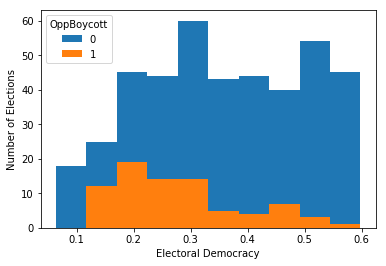

In [200]:
X.pivot(columns="OppBoycott", values="v2x_polyarchy").plot.hist()
plt.xlabel("Electoral Democracy")
plt.ylabel("Number of Elections")

In [2]:
cheat = pd.read_csv('replication_data.csv')

In [9]:
cheat['country_x'].value_counts().head(10)

Malaysia              13
Turkey                13
Albania               13
Thailand              12
Philippines           11
Singapore             11
Colombia              10
South Africa          10
Dominican Republic    10
Guatemala              9
Name: country_x, dtype: int64